In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Loading the Dataset

In [2]:
marks_data  = pd.read_csv('marks.txt', names=["Exam 1", "Exam 2", "Admission?"])
marks_data.head()

,Exam 1,Exam 2,Admission?
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


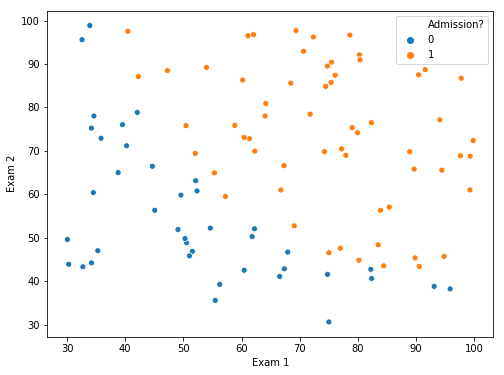

In [3]:
# let's visualize the data
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Exam 1", y = "Exam 2", hue="Admission?", data=marks_data)

# Preparing the Data

In [4]:
x  = marks_data.iloc[:, :-1]
y = marks_data.iloc[:, -1]

# Building the Model

In [5]:
class LogisticRegression:
    '''The Logistic Regression Algorithm'''
    
    def __init__(self, alpha=0.05, iters=1000, standardize=False):
        self.alpha = alpha # learning rate
        self.iters = iters # no of iterations
        self.standardize = standardize
        
    def sigmoid(self, inpt):
        return 1/(1+np.exp(-inpt))
    
    def cost_func(self, h, y): # h - output after passing through the sigmoid function
        m = len(y)
        first_term = np.dot(y.T, np.log(h))
        second_term = np.dot((1-y).T, np.log(1-h))
        loss = (-1/m) * (first_term + second_term).sum()
        return loss
        
    def fit(self, x, y):
        
        if self.standardize:
            x = (x-np.min(x, axis=0))/(np.max(x, axis=0) - np.min(x, axis=0))
        
        # adding an additional '0' Feature
        x = np.c_[np.ones(x.shape[0]), x]

        y = y[:, np.newaxis] # making it a row vector
        m = len(y)
        
        # defining the coefficients
        coeffs = np.ones(x.shape[1])
        coeffs = coeffs[:, np.newaxis]
        
        # gradient descent
        cost_func_history = []
        for i in range(self.iters):
            predicts = self.sigmoid(np.dot(x, coeffs))
            error = predicts - y
            gradient = (1/m)*np.dot(x.T, error)
            coeffs -= self.alpha * gradient
            cost_func_history.append(self.cost_func(predicts, y))

        self.coeffs = coeffs
        return cost_func_history
        
    def predict_prob(self, x):
        return self.sigmoid(np.dot(x, self.coeffs))
    
    def predict(self, x, threshold=0.5):
        if self.standardize:
            x = (x-np.min(x, axis=0))/(np.max(x, axis=0) - np.min(x, axis=0))
        
        # adding an additional '0' Feature
        x = np.c_[np.ones(x.shape[0]), x]
        
        prob = self.predict_prob(x)
        result = prob>0.5 
        def bool_to_result(inpt):
            if inpt:
                return 1
            else:
                return 0
        return np.array(list(map(lambda x: bool_to_result(x), result)))
            

In [6]:
model = LogisticRegression(iters=80000, standardize=True) 
# Observation: cost function runs without errors only when the data is normalized/standardized
cf = model.fit(x, y)

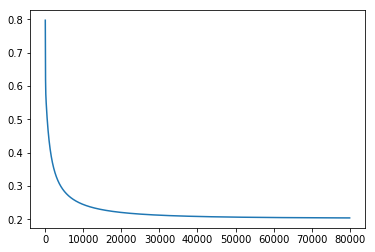

In [7]:
plt.plot(cf)

In [8]:
predicts = model.predict(x)

In [9]:
# let's check the accuracy of our model
(predicts == y).mean()

0.89

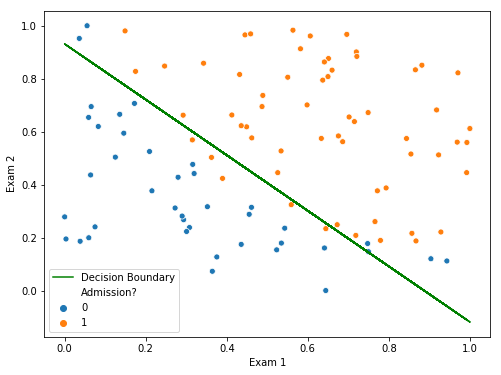

In [10]:
# let's plot the decision boundary
# h(x) = theta0 + theta1.x1 + theta2.x2
# set h(x) = 0. and then x2 becomes the new y (since the graph is x2 vs x1)

# first we need to normalize the x values since we standardized in the model
# let's normalize the dataset
data_new = marks_data.copy()
data_new.iloc[:, [0, 1]] = data_new.iloc[:, [0, 1]].apply(lambda x: (x - x.min())/(x.max()-x.min()))

x11 = data_new.iloc[:, 0]
x2 = -(model.coeffs[0] + model.coeffs[1]*x11)/model.coeffs[2]

plt.figure(figsize=(8, 6))
sns.scatterplot(x="Exam 1", y="Exam 2", hue="Admission?", data=data_new)
plt.plot(x11, x2, color="g", label="Decision Boundary")
plt.legend()

# Using Another Optimization Function

In [12]:
# let's choose a different optimization algorithm other than gradient descent
# Note:- This will not work if n(number of features) is less than 2
# these are much faster then gradient descent

# you have to reshape in the function again even if you've changed the dimensions here

x1a = data_new.iloc[:, :-1]
x1a = np.c_[np.ones(x1a.shape[0]), x1a]

y1a = data_new.iloc[:, -1]
y1a = y1a[:, np.newaxis]

initial_coeffs = np.ones(x1a.shape[1])
initial_coeffs = initial_coeffs[:, np.newaxis]

import scipy.optimize as op

def cost_func(coeffs, x, y): # h - output after passing through the sigmoid function
    
    # reshaping
    m, n = x.shape
    coeffs = coeffs.reshape((n, 1))
    y = y.reshape((m, 1))
    
    h = sigmoid(np.dot(x, coeffs))
    first_term = np.dot(y.T, np.log(h))
    second_term = np.dot((1-y).T, np.log(1-h))
    loss = (-1/m) * (first_term + second_term).sum()
    return loss

def sigmoid(inpt):
    return 1/(1+np.exp(-inpt))

def gradient(coeffs, x, y):
    
    # Note:- You need to reshape in the function itself before plunging into the optimization function
    #        otherwise, it'll show error. Especially for the gradient function
    m , n = x.shape
    coeffs = coeffs.reshape((n, 1))
    y = y.reshape((m, 1))
    
    m = len(y)
    h = sigmoid(np.dot(x, coeffs))
    error = h - y
    grad = (1/m) * (np.dot(x.T, error))
    return grad.flatten() # falttening is not required

result = op.minimize(fun=cost_func, x0=initial_coeffs, args=(x1a, y1a),
                          method='TNC', jac=gradient)
optimal_coeffs = result.x

In [13]:
# let's compare our gradient descent coefficients with the optimization function coefficients

print(optimal_coeffs)
print()
print(model.coeffs.flatten()) 

# they're almost the same

[-12.79591207  14.3879593   13.75293889]

[-11.59481529  13.07315568  12.45226138]


References:
<br>https://medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac
<br>https://towardsdatascience.com/building-a-logistic-regression-in-python-301d27367c24
<br>https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae